# **Importing Libraries**

In [27]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F

In [28]:
# reproducing same results
SEED = 2019

# torch
torch.manual_seed(SEED)

# **2 Load Dataset**

In [29]:
# open text file and read in data
with open("Dailog-dataset.dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

In [30]:
# number of text sequences
len(dialogs)

64776

In [31]:
# print 10 random dialogs
random.sample(dialogs, 10)

["Hey Janice! I'm thinking of making a reservation at a seafood place for dinner tomorrow",
 'What time does the restuarant close?',
 'and extra cinnamon',
 'Terrific, thank you',
 'Actually can you add green pepper for half of the pizza',
 'Do I need to bring anything else',
 "Think I'll go with regular",
 'Okay that is fine',
 'How much will this cost',
 'Sorry, I cannot make it that early']

# **3 Preprocessing and Exploring Text Data**

# **3.1 Text Cleaning**

In [32]:
# text cleaning
dialogs_clean = []

for i in dialogs:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i)
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  dialogs_clean.append(i)

In [33]:
random.sample(dialogs_clean, 10)

['they make it with skim milk',
 'i said no romance movies',
 ' and can you get it gluten free',
 'tonight if possible',
 'hello pa can you get me to intelligent auto solutions',
 'i prefer a booth',
 'your very welcome',
 'thats everything thank you ',
 'any good specials online from dominos today',
 'pizza hut the closest near me for pickup']

# **3.2 Finding Word Count**

In [34]:
# get list of all the words
all_words = " ".join(dialogs_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:   
  # check if the word is already in dictionary 
  if word in words_dict:
    # increment count of word by 1 
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1 
    words_dict[word] = 1

In [35]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [36]:
# vocabulary size
len(words_df)

11147

In [37]:
words_df.head()

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1
3,andrea,1
4,precice,1


In [38]:
words_df.tail()

,word,count
11142,you,11909
11143,a,13380
11144,to,14000
11145,the,15406
11146,i,19654


# **3.3 Find and Replace Rare Words with "Unknown" Token**

In [39]:
# user specified threshold value
rare_thresh = 4

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [40]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 69.03
Rare words coverage in the corpus: 2.27


In [41]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

**Let's see the technique that we will use to replace the rare words/tokens in the dataset with a special token known as the unknown token ("")**

In [42]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i)

print(pattern)

day|book|


In [43]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [44]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [45]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list 
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
for d in tqdm_notebook(dialogs_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [46]:
dialogs_clean_v2[520:530]

['does it serve traditional chinese dessert',
 'how much extra time to reach <unk> ',
 'ok lets reserve a table for dinner at hakkasan',
 'hello i need to get a car please',
 'holiday inn <unk> parkconv <unk> convention center drive <unk> park il',
 'bowling alley <unk> highway <unk> park il',
 'what types of cars does uber have',
 "what's the price difference",
 'ok get me the cheapest please',
 'ok then get me the next level']

# **4. Data Preparation**

# **4.1 Prepare Sequences**

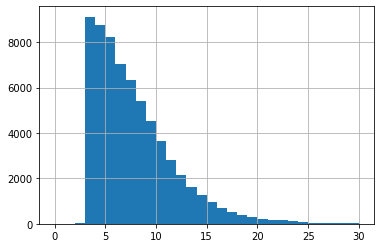

In [47]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

In [48]:
# function to create sequences of equal length
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [49]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2]

In [50]:
seqs[:10]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"],
 ["no that's it just book"],
 ['hi i would like to see',
  'i would like to see if',
  'would like to see if the',
  'like to see if the movie',
  'to see if the movie what',
  'see if the movie what men',
  'if the movie what men want',
  'the movie what men want is',
  'movie what men want is playing',
  'what men want is playing here'],
 ['yes for m

In [51]:
# merge list-of-lists into a single list
seqs = sum(seqs, [])

In [52]:
seqs[:15]

["hi i'm looking to book a",
 "i'm looking to book a table",
 'looking to book a table for',
 'to book a table for korean',
 'book a table for korean fod',
 'somewhere in southern nyc maybe the',
 'in southern nyc maybe the east',
 'southern nyc maybe the east village',
 "we don't want to sit at",
 "don't want to sit at the",
 'want to sit at the bar',
 'to sit at the bar but',
 'sit at the bar but anywhere',
 'at the bar but anywhere else',
 'the bar but anywhere else is']

In [53]:
# count of sequences
len(seqs)

205346

In [54]:
# create input and target sequences (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [55]:
x[0], y[0]

("hi i'm looking to book", "i'm looking to book a")

In [56]:
x[88543], y[88543]

('to drive to several locations', 'drive to several locations do')

# **4.2 Create Token-Integer Mappings**

In [57]:
# create integer-to-token mapping
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

# create token-to-integer mapping
token2int = {t: i for i, t in int2token.items()}

In [58]:
token2int["can"], int2token[1127]

(3847, 'brasa')

# **4.3 Split Data into Train and Validation Sets**

In [59]:
# train-validation split
# input sequences
x_tr = x[:150000]
x_val = x[150000:]

# target sequences
y_tr = y[:150000]
y_val = y[150000:]

# **4.4 Pad Sequences**

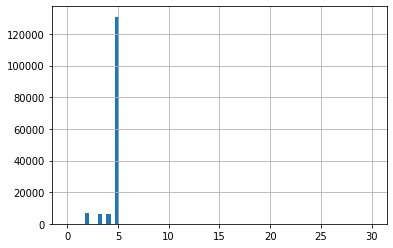

In [60]:
# plot sequence length in train set
text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

In [61]:
# based on the plot above
max_text_len = 5

# function to perform padding
def pad_sequence(seq, n):

  # split input sequence into tokens
  seq = seq.split()
  
  # check if no. of tokens in input sequence is less than 'n'
  if len(seq) < n:
    for i in range(n - len(seq)):
      seq.append("<pad>")

  return " ".join(seq)

# pad text sequences (train set)
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

# pad text sequences (validation set)
x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [62]:
x_tr_padded[:20]

["hi i'm looking to book",
 "i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'somewhere in southern nyc maybe',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 "we don't want to sit",
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'what times are <pad> <pad>',
 "yikes we can't do those",
 'let me <pad> <pad> <pad>',
 "great let's book <pad> <pad>"]

In [63]:
y_tr_padded[:20]

["i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'a table for korean fod',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 'nyc maybe the east village',
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'but anywhere else is fine',
 'times are available <pad> <pad>',
 "we can't do those times",
 'me check <pad> <pad> <pad>',
 "let's book that <pad> <pad>"]

In [64]:
# update mapping dictionaries
int2token[0] = "<pad>"
token2int["<pad>"] = 0

# set vocabulary size
vocab_size = len(int2token)

# **4.5 Convert Text Sequences to Integer Sequences**

In [65]:
# function to create integer sequences
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

In [66]:
# convert text sequences to integer sequences
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [67]:
x_tr_int[:10]

[[460, 198, 5255, 2340, 4609],
 [198, 5255, 2340, 4609, 4623],
 [5255, 2340, 4609, 4623, 2996],
 [2340, 4609, 4623, 2996, 5774],
 [4609, 4623, 2996, 5774, 5589],
 [2943, 6261, 4351, 5165, 1223],
 [6261, 4351, 5165, 1223, 3109],
 [4351, 5165, 1223, 3109, 4430],
 [3787, 5177, 1544, 2340, 3153],
 [5177, 1544, 2340, 3153, 1167]]

In [68]:
y_tr_int[:10]

[[198, 5255, 2340, 4609, 4623],
 [5255, 2340, 4609, 4623, 2996],
 [2340, 4609, 4623, 2996, 5774],
 [4609, 4623, 2996, 5774, 5589],
 [4623, 2996, 5774, 5589, 341],
 [6261, 4351, 5165, 1223, 3109],
 [4351, 5165, 1223, 3109, 4430],
 [5165, 1223, 3109, 4430, 2556],
 [5177, 1544, 2340, 3153, 1167],
 [1544, 2340, 3153, 1167, 3109]]

In [69]:
# convert lists into numpy arrays
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((150000, 5), (150000, 5), (55346, 5), (55346, 5))

# **5. Model Building**

# **5.1 Define Model Architecture**

In [70]:
# define model architecture

## embedding layer: 
##    input dim = vocab_size, 
##    ouput dim = 200

## LSTM layer:
##    input dim = 200
##    hidden units = 256
##    layers = 2
##    output dim = 256

## Dropout Layer
##    input dim = 256
##    output dim = 256

## fully connected layer
##    input dim = 256
##    ouput dim = vocab_size

class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features)...
    # ...therefore we need batch_first=True
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    
    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)
    
    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    ''' Forward pass through the network. 
        These inputs are x, and the hidden/cell state is `hidden`. '''

    ## pass input through embedding layer
    embedded = self.emb_layer(x)  

    ## Get the outputs and the new hidden state from the lstm
    lstm_output, hidden = self.lstm(embedded, hidden)
    
    ## pass through a dropout layer
    out = self.dropout(lstm_output)
    
    ## reshape the tensor to the shape (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)

    ## put "out" through the fully-connected layer
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden
    
    
  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

In [71]:
# define and print the net
net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(6502, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6502, bias=True)
)


In [72]:
# function to generate batches
def get_batches(arr_x, arr_y, batch_size):
  # iterate through the arrays
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    # batch of input sequences
    x = arr_x[prv:n,:]

    # batch of target sequences
    y = arr_y[prv:n,:]

    prv = n
    
    yield x, y

# **5.2 Start Model Training**

In [73]:
def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
      
  # set initial loss to infinite
  best_valid_loss = float('inf')
  
  # optimizer
  opt = torch.optim.Adam(net.parameters(), lr=lr)
  
  # loss function
  criterion = nn.CrossEntropyLoss()
  
  if(torch.cuda.is_available()):
    # push model to GPU
    net.cuda()
  
  counter = 0

  net.train()

  for e in range(epochs):
            

    # iterate over batches
    for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
      counter+= 1
      
      # convert arrays to tensors
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      
      if(torch.cuda.is_available()):
        # push tensors to GPU
        inputs, targets = inputs.cuda(), targets.cuda()

      # initialize hidden state
      h = net.init_hidden(batch_size)

      # set accumulated gradients to zero
      net.zero_grad()
      
      # get the output from the model
      output, h = net(inputs, h)
      
      # calculate the loss and perform backprop
      loss = criterion(output, targets.view(-1))
      loss.backward()
      
      opt.step()
      
      if counter % print_every == 0:
        # Get validation loss
        
        val_losses = []

        net.eval()
        for x, y in get_batches(x_val_int, y_val_int, batch_size):
            
          x, y = torch.from_numpy(x), torch.from_numpy(y)
          
          val_h = net.init_hidden(batch_size)

          inputs, targets = x, y
          if(torch.cuda.is_available()):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)

          val_loss = criterion(output, targets.view(-1))
          val_losses.append(val_loss.item())

        #save the best model
        if np.mean(val_losses) < best_valid_loss:
          best_valid_loss = np.mean(val_losses)
          torch.save(net.state_dict(), 'saved_weights.pt')

        net.train()

      
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [74]:
# specify batch size
batch_size = 64

# train the model
train(net, batch_size = batch_size, epochs=10)

Epoch: 1/10... Step: 32... Loss: 6.4784... ppl: 670.9487  Val Loss: 6.5087
Epoch: 1/10... Step: 64... Loss: 5.6409... ppl: 343.3518  Val Loss: 5.8388
Epoch: 1/10... Step: 96... Loss: 6.0772... ppl: 276.1961  Val Loss: 5.6211
Epoch: 1/10... Step: 128... Loss: 5.2709... ppl: 239.6580  Val Loss: 5.4792
Epoch: 1/10... Step: 160... Loss: 6.2045... ppl: 211.6844  Val Loss: 5.3551
Epoch: 1/10... Step: 192... Loss: 5.7582... ppl: 189.2365  Val Loss: 5.2430
Epoch: 1/10... Step: 224... Loss: 5.1731... ppl: 172.1208  Val Loss: 5.1482
Epoch: 1/10... Step: 256... Loss: 4.3078... ppl: 157.8676  Val Loss: 5.0618
Epoch: 1/10... Step: 288... Loss: 4.8329... ppl: 145.5787  Val Loss: 4.9807
Epoch: 1/10... Step: 320... Loss: 4.9814... ppl: 136.7871  Val Loss: 4.9184
Epoch: 1/10... Step: 352... Loss: 4.4209... ppl: 127.5081  Val Loss: 4.8482
Epoch: 1/10... Step: 384... Loss: 5.1342... ppl: 118.4260  Val Loss: 4.7743
Epoch: 1/10... Step: 416... Loss: 4.9139... ppl: 112.6923  Val Loss: 4.7247
Epoch: 1/10... 

# **6. Text Generation**

In [75]:
#load weights of best model
path = 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [76]:
# function to generate one token
def predict(net, tkn, h=None):
         
  # tensor inputs
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)
  
  if(torch.cuda.is_available()):
      inputs = inputs.cuda()

  # get the output of the model
  out, h = net(inputs, h)

  # get the token probabilities
  p = F.softmax(out, dim=1).data

  if(torch.cuda.is_available()):
      p = p.cpu()

  p = p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]
  
  # return the encoded value of the predicted char and the hidden state
  return int2token[sampled_token_index], h

In [77]:
# function to fetch generated sequence
def sample(net, size = 2, seed_text='it is'):
        
    if(torch.cuda.is_available()):
        net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = seed_text.split()

    # predict next token
    for t in toks:
      token, h = predict(net, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [78]:
# seed texts
seeds = ["i want to",
         "how about a cup",
         "i don't want",
         "can you send",
         "my car"]

# number of tokens to generate
num_toks = 6

# text generation
for s in seeds:
  # get generated text from the model
  text_gen = sample(net, num_toks, seed_text=s)
  # print the result
  print("seed text:", s, ">> output:",text_gen)
  print("\n")

seed text: i want to >> output: i want to order a pizza from pizza hut


seed text: how about a cup >> output: how about a cup of caramel mocha with coconut milk


seed text: i don't want >> output: i don't want to drive it to the office


seed text: can you send >> output: can you send me the confirmation to my phone


seed text: my car >> output: my car is making a weird noise when


